# Applying ULMFiT to Classify Airline Sentiments

_Created by:_ Lewis Tunstall, October 2019

In this notebook we aim to build a natural language model that can accurately classify the sentiment of Tweets (positive, neutral, or negative) associated with major U.S. airlines. From a business perspective, sentiment analysis is an effective tactic for customer service and support representatives, as they can react efficiently and monitor dissatisfaction before negative sentiments from passengers spread.

The focus of our analysis is the [Twitter Airline sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) dataset (alternative download [here](https://www.figure-eight.com/data-for-everyone/)) which contains 14,640 tweets collected over a one week period in February 2015. Although this dataset is fairly small by deep learning standards, it has been shown in the ULMFiT [paper](https://arxiv.org/abs/1801.06146) that state-of-the-art results can be obtained on a small number of labelled samples. 

## Table of Contents
* [Load and explore the data](#data-eda)
* [Visualising sentiments](#data-viz)
* [Prepare the data](#data-prep)
* [Create a test set](#testset)
* [Experiment 1: ULMFiT baseline](#ulmfit-baseline)

## Load libraries

In [1]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path

# ml magic
import fastai
from fastai.vision import ClassificationInterpretation
from fastai.text import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from torch import *
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# dataviz
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas(desc="progress")

## Utility functions

### Data viz

In [2]:
def plot_time_series_groups(tweets, column_name):
    '''
    A helper function to plot time series as a stacked area chart across categories.
    
    Args:
        tweets (pandas.DataFrame): The DataFrame of tweets.
        column_name (str): The name of the DataFrame column to plot the categories of.
    '''
    
    # plot daily sentiments as stacked area chart
    ts_sentiment = (tweets
                    .groupby(['tweet_created', column_name])
                    .count()['tweet_id']
                    .unstack()
                   )

    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(12,4))
        ts_sentiment.resample('1D').count().plot.area(x_compat=True, ax=ax)
        # set x-ticks to daily interval and add legend
        ax.xaxis.set_major_locator(mdates.DayLocator())
        # format x-tick labels as 3-letter month name and day number
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));
        # place legend outside of figure
        plt.legend(bbox_to_anchor=(1.01,1.01))
        plt.tight_layout()

### Data loading

In [3]:
def prepare_and_load_data():
    """
    Load train, test, and vaidation sets and apply text preprocessing.
    
    Returns:
        dfs['train'] (pandas.DataFrame): The training set.
        dfs['test'] (pandas.DataFrame): The test set.
        dfs['valid'] (pandas.DataFrame): The validation set.
        class_names: The list of class names (positive, neutral, negative).
    """
    
    dfs = {}
    
    for data in ['train', 'test', 'valid']:
        df = pd.read_csv(DATA.joinpath(f'{data}_all-fields.csv'))
        df = df[['sentiment', 'text']]
        df.to_csv(DATA.joinpath(f'{data}.csv'), index=False)
        dfs[data] = df
        
    class_names = list(dfs['train']['sentiment'].unique())
        
    return dfs['train'], dfs['test'], dfs['valid'], class_names

### Validation

In [4]:
class_dict = {
    0:'negative',
    1:'neutral',
    2:'positive'
}

def get_predictions(dataset_type, learn, y_test, y_valid):
    """
    Gets predictions on test or validation sets and generates classification report.
    
    Args:
        dataset_type (str): The dataset to run inference on. Can be 'test' or 'valid'.
        learn: The learner object to get predictions from.
        y_test (arr): A NumPy array of ground truth labels from test set.
        y_valid (arr): A NumPy array of ground truth labels from validation set.
    """
    
    if dataset_type == 'test':
        preds, targets = learn.get_preds(DatasetType.Test, ordered=True)
        y_true = y_test
    elif dataset_type == 'valid':
        preds, targets = learn.get_preds(DatasetType.Valid, ordered=True)
        y_true = y_valid

    predictions = np.argmax(preds, axis=1)
    preds_df = pd.DataFrame({'preds':predictions.numpy()})
    preds_df['test_preds'] = preds_df['preds'].map(class_dict)
    print('='*10, f'Classification report on {dataset_type} set', '='*16)
    print(classification_report(y_true, preds_df['test_preds']))
    print('='*61)

## Load and explore the data  <a class="anchor" id="data-eda"></a>

Let's load the data and take a quick look at the data structure:

In [5]:
# path to data storage on Paperspace - change this for your environment
DATA = Path('./')
!ls {DATA}

airline-tweets.csv    sentiment-analysis.html	train_all-fields.csv
airline_lm_vocab.pkl  sentiment-analysis.ipynb	valid.csv
exp-01_tmp-lm	      test.csv			valid_all-fields.csv
fellowshipai	      test_all-fields.csv
models		      train.csv


In [6]:
tweets = pd.read_csv(DATA.joinpath('airline-tweets.csv')); tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [7]:
tweets.shape

(14640, 15)

There are 15 attributes, so let's get a quick description of the each one's type and number of non-null values:

In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


Evidently the `airline_sentiment_gold`, `negativereason_gold`, and `tweet_coord` attributes are missing most of their values; fortunately we are not likely to need them for the classification task. 

Next, let's have a look to see if there are any duplicated tweets:

In [9]:
num_duplicates = len(tweets) - tweets['tweet_id'].nunique()
print(f'Number of duplicates: {num_duplicates}')

Number of duplicates: 155


Let's drop these from the dataset to avoid bleeding information from the test set into the training set:

In [10]:
tweets = tweets.copy().drop_duplicates(subset='tweet_id').reset_index(drop=True)
print(f'Number of tweets after deduplication: {len(tweets)}')

Number of tweets after deduplication: 14485


Finally let's have a look at how the tweets are distributed by sentiment:

In [11]:
tweets['airline_sentiment'].value_counts(normalize=True)

negative    0.626993
neutral     0.211874
positive    0.161132
Name: airline_sentiment, dtype: float64

Unsurprisingly for a real-world dataset we have a moderate amount of class imbalance, with the majority of tweets belonging to the negative class. We will need to take care of this later by upsampling the minority classes to create classifiers with better performance.

## Create train, test, and validation sets <a class="anchor" id="testset"></a>
Before diving into the model-building phase, let's create a test set to limit ourselves from the [data snooping](https://web.ma.utexas.edu/users/mks/statmistakes/datasnooping.html) bias. To guarantee that the test set is representative of the full dataset we use [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling):

In [12]:
# rename target for simplicity
tweets.rename(columns={'airline_sentiment':'sentiment'}, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(tweets, tweets['sentiment']):
    train_set, test_set = tweets.loc[train_index], tweets.loc[test_index]

Next let's create a validation set by splitting the training set one more time:

In [13]:
# reset index order from train / test split
train_set.reset_index(drop=True, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, valid_index in split.split(train_set, train_set['sentiment']):
    train_set, valid_set = train_set.loc[train_index], train_set.loc[valid_index]

As a sanity check, let's look at the sentiment proportions in the train, validation, and test sets:

In [14]:
print(f'Number of training samples: {len(train_set)}')
train_set['sentiment'].value_counts(normalize=True)

Number of training samples: 9270


negative    0.627077
neutral     0.211866
positive    0.161057
Name: sentiment, dtype: float64

In [15]:
print(f'Number of validation samples: {len(valid_set)}')
valid_set['sentiment'].value_counts(normalize=True)

Number of validation samples: 2318


negative    0.626833
neutral     0.211821
positive    0.161346
Name: sentiment, dtype: float64

In [16]:
print(f'Number of test samples: {len(test_set)}')
test_set['sentiment'].value_counts(normalize=True)

Number of test samples: 2897


negative    0.626855
neutral     0.211943
positive    0.161201
Name: sentiment, dtype: float64

The distribution across all three sets look good, so let's save them to disk for later use:

In [17]:
train_set.to_csv(DATA.joinpath('train_all-fields.csv'), index=False)
test_set.to_csv(DATA.joinpath('test_all-fields.csv'), index=False)
valid_set.to_csv(DATA.joinpath('valid_all-fields.csv'), index=False)

## Visualising sentiments  <a class="anchor" id="data-viz"></a>
Next let's gain a deeper understanding of the data by generating some plots concerning the sentiments.  First we create a copy of the training set:

In [18]:
tweets = pd.read_csv(DATA.joinpath('train_all-fields.csv'))

### Time series
A natural place to start is to see how the sentiment classes evolve in time. To do that we format the timestamp and create a helper function for reuse:

In [19]:
tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])

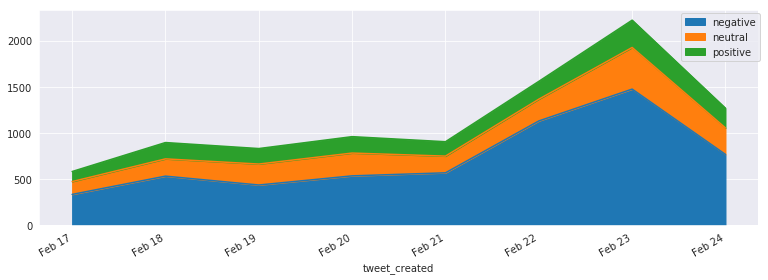

In [20]:
plot_time_series_groups(tweets, 'sentiment')

From the figure we see that there was a spike in negative comments over February 22-23. Let's try to see what the main cause was:

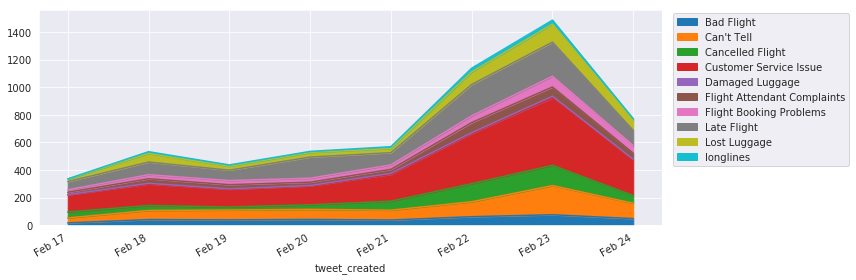

In [21]:
plot_time_series_groups(tweets, 'negativereason')

Although customer service seems to be main driver of the spike, it's not clear whether this is simply related to the fact that the number of late and cancelled flights also increased during this time (and where passengers are likely to be irate). 

### Distribution by airline company
Next let's look at how the sentiments are distributed across the various airline companies:

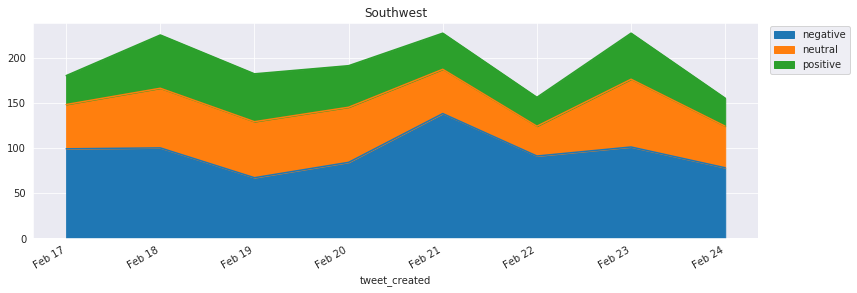

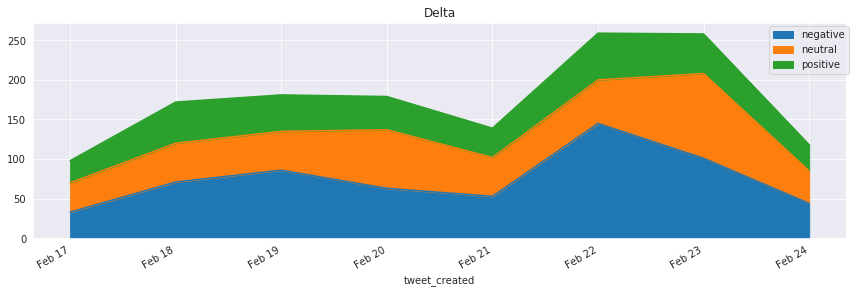

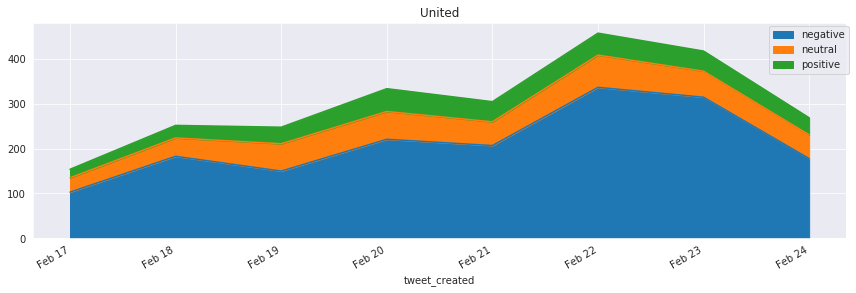

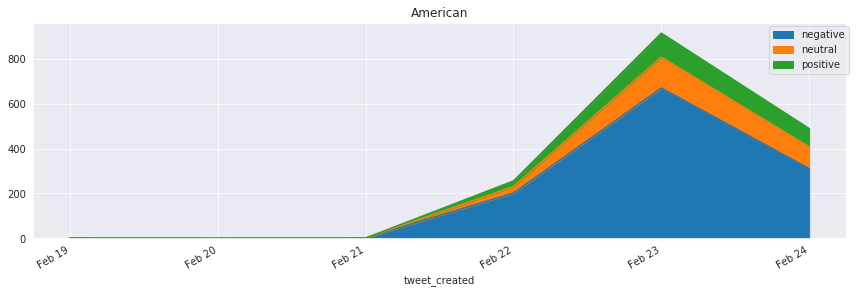

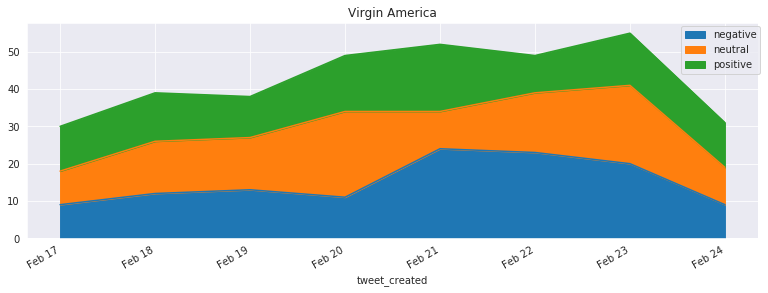

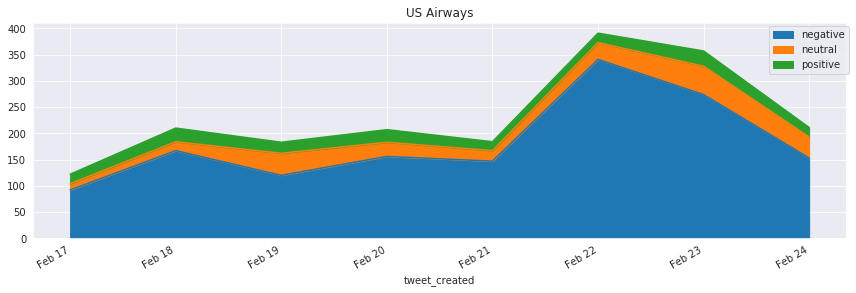

In [22]:
for airline in tweets['airline'].unique():
    plot_time_series_groups(tweets.query(f'airline == "{airline}"'), 'sentiment')
    plt.title(airline)

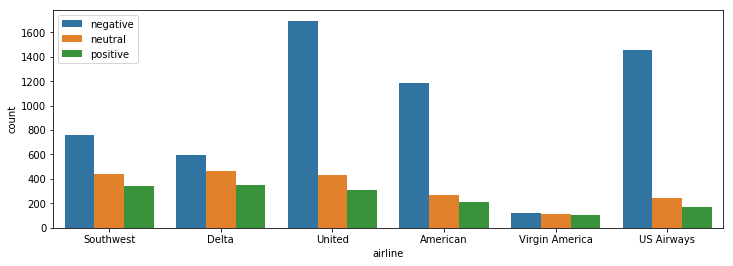

In [23]:
plt.figure(figsize=(12,4))
sns.countplot(x='airline', hue='sentiment', data=tweets)
plt.legend(loc='upper left')
plt.show()

From the figures we see that for all airlines except Virgin America the number of negative tweets is typically much greater than neutral or positive ones (in that order). In particular, American, United, and US Airways appear to be the main drivers responsible for the spike of negative tweets around February 22-23. 

Given that American, Delta, Southwest, and Delta are the top 4 airlines in terms passengers carried (source [here](https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America)), it is not surprising to see that they attract the greatest share of tweets. Interestingly, [this](https://www.wsj.com/articles/the-best-and-worst-airlines-of-2015-1452709957) WSJ article show that the airlines in our dataset were ranked as follows in 2015:

* United: 7/9
* Delta: 3/9
* American: 9/9
* US Airways: NA (merged with American in April, 2015)
* Southwest: 4/9
* Virgin America: 2/9

These rankings are actually borne out in the data and can be seen if we calculate the ratio of negative to positive tweets per airline:

In [24]:
(tweets
 .groupby(['airline', 'sentiment'])
 .size()
 .unstack()
 .assign(pos_neg_ratio = lambda x: x.positive / x.negative)
 .sort_values(by='pos_neg_ratio', ascending=False)
)

sentiment       negative  neutral  positive  pos_neg_ratio
airline                                                   
Virgin America       121      117       105       0.867769
Delta                597      463       347       0.581240
Southwest            758      442       344       0.453826
United              1695      433       312       0.184071
American            1189      265       214       0.179983
US Airways          1453      244       171       0.117688

For reference, the [WSJ](https://www.wsj.com/articles/the-best-and-worst-u-s-airlines-of-2018-11547648032) scorecard from 2018 is:

* United: 5/8
* Delta: 1/8
* American: 7/8
* US Airways: NA (merged with American in April, 2015)
* Southwest: 3/8
* Virgin America: 2/8 (merged with Alaska in 2017)

which shows that the ranking has not changed too drastically in the last few years and that American is generally to be avoided!

As a final look into the airlines, let's see how the negative reasons distribute across them:

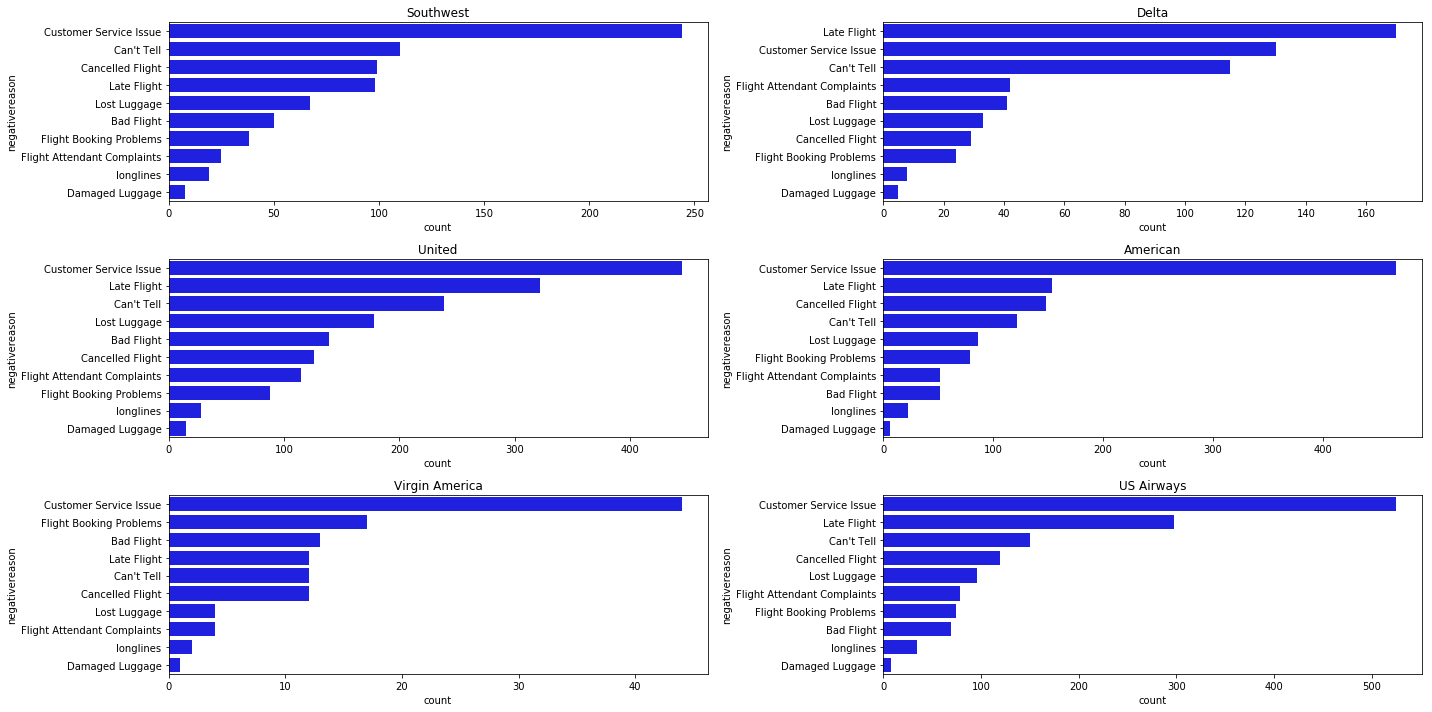

In [25]:
airlines = tweets['airline'].unique()

fig = plt.figure(figsize=(20,10))

for airline, num in zip(airlines, range(1, len(airlines) + 1)):
    tmp = tweets.query(f'airline == "{airline}"')
    ax = fig.add_subplot(3,2,num)
    sns.countplot(y='negativereason', data=tmp, ax=ax, color='b', order = tmp['negativereason'].value_counts().index)
    ax.set_title(airline)

plt.tight_layout()
plt.show()

As expected, the dominant negative reasons tend to be customer service and late or cancelled flights.

### Tweet length
To wrap up our exploratory analysis, let's have a quick look at the distribution of tweet lengths across each sentiment:

In [26]:
tweets['tweet_length'] = tweets['text'].apply(len)

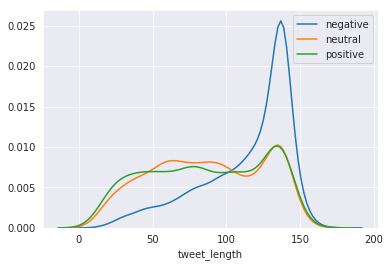

In [27]:
with sns.axes_style("darkgrid"):
    for sentiment in tweets['sentiment'].unique():
        subset = tweets.query(f'sentiment == "{sentiment}"')
        sns.distplot(subset['tweet_length'], hist=False, label=sentiment)

From the figure we see that the negative tweets tend to be the longest ones; contra the general advice "If you don't have something nice to say, don't say anything at all"!

---
### The story so far

We can sumarise the results from our exploratory analysis as follows:

* There is moderate class imbalance across the sentiments, with proportions

| Sentiment | % of Tweets |
| :---: | :---: |
| negative | 62.7 |
| neutral |    21.2 |
| positive |   16.1 |

* There was a spike of negative tweets around February 22-23 which appears to be driven by late flights and poor customer service. The majority of negative tweets are directed towards American, United, and US Airways.
* Unsuprisingly, customer service appears to be the main driver of negative tweets for most airlines.
* The longest tweets also tend to be the negative ones.

---

## Prepare the data  <a class="anchor" id="data-prep"></a>
Here we load the train, test, and validation dataset, and apply some basic text processing that's needed for our baseline models.

In [28]:
train_df, test_df, valid_df, class_names = prepare_and_load_data()

In [29]:
# take a peek to make sure the data is loaded correctly
for df in [train_df, test_df, valid_df]:
    display(df.head())

sentiment                                               text
0  negative  @SouthwestAir Anyone answering phone this morn...
1   neutral  @JetBlue We already won the tickets but she's ...
2  positive  @united Anna Palm Springs gate 19  deserves a ...
3  positive  @AmericanAir Lets hope it stays that way.Big t...
4  negative  @VirginAmerica on VX399 from JFK to LA - dirty...

sentiment                                               text
0  negative  @united my flight was already Cancelled Flight...
1  negative  @JetBlue the whole plane. Hoping for better lu...
2   neutral  @VirginAmerica Really missed a prime opportuni...
3   neutral  @USAirways well, depending on the policy will ...
4   neutral  @JetBlue For my Grandma Ella's 80th, she would...

sentiment                                               text
0  negative  @united I would have made it if you hadn't alr...
1   neutral  @united just emailed Jim Compton and Jeff Smis...
2  positive  @SouthwestAir Hi! I ❤️ your company and fly al...
3  negative  @USAirways #428 delayed due to #frozentoilet #...
4  negative  @USAirways horrible customer service, flying f...

## Experiment 1: ULMFiT baseline <a class="anchor" id="ulmfit-baseline"></a>
In this step we apply ULMFiT without any major tuning; the goal is to set a strong benchmark from which we can build upon. As described in both the ULMFiT [paper](https://arxiv.org/abs/1801.06146) and [lesson 4](https://course.fast.ai/videos/?lesson=4) from the fast.ai MOOC, the general procedure for building a classifier with ULMFiT is as follows:

1. Pre-train a language model (LM) with a large corpus of text, typically Wikipedia
2. Fine-tune that LM on the text data to be used on the target task
3. Train a classifier on top of the fine-tuned LM

In this section we use the pretrained language model `wikitext-103`, so only steps 2 & 3 need to be performed. Although one expects that the idiosyncracies of tweets to be significantly different from Wikipedia text, the general idea is that step one is focused on trying to predict the next word in a sequence and thus learn the broad structure of the English language. In any case, this provides a natural starting point upon which further models / tweaks can be applied.

### Language model fine-tuning
To fine-tune a pretrained language model we need to perform the following steps:

1. Load and tokenize the target task's vocabulary
2. Initialise the language model with the pretrained vocabulary
3. Find the optimal learning rate
4. Fit the head of the model
5. Unfreeze all the layers and train

#### Load and tokenize

In [30]:
data_lm = TextLMDataBunch.from_df(DATA, train_df=train_df, valid_df=valid_df, test_df=test_df)
data_lm.save('exp-01_tmp-lm')
data_lm.show_batch()

In [31]:
# save the vocab for later use
pickle.dump(data_lm.train_ds.vocab, open(f'airline_lm_vocab.pkl','wb'))

#### Initialise the language model

In [32]:
# use default dropout from fast.ai MOOC
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

#### Find the optimal learning rate
Here we look for the largest negative slope, typically a factor of 10 or so smaller than the location of the minimum:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


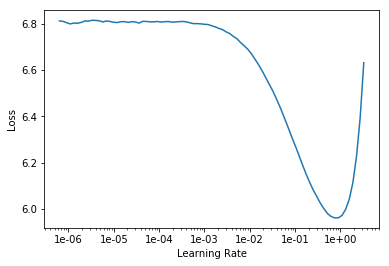

In [33]:
learn.lr_find()
learn.recorder.plot()

#### Fit the head

In [34]:
learn.fit_one_cycle(cyc_len=1, max_lr=5e-2, moms=(0.8, 0.7))

In [35]:
learn.save('exp-01_fit-head')

In [36]:
learn.load('exp-01_fit-head');

#### Unfreeze all layers

In [37]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=3, max_lr=5e-3, moms=(0.8, 0.7))

In [38]:
learn.save('exp-01_lm_fine-tuned')
learn.save_encoder('exp-01_lm_fine-tuned-enc')

### Train classifier
Now that we have a language model fine-tuned on our tweet data, the next step is to perform the classification task. This involves the following steps:

1. Load and tokenise the training data
2. Initialise the learner object
3. Find the optimal learning rate
4. Gradually unfreeze the layers
5. Evaluate predictions on validation and test sets

In [39]:
# config parameters
drop_mult = 0.5
moms = (0.8,0.7)
wd = 0.1

#### Load and tokenise

In [40]:
# load vocabulary from LM fine-tuning
vocab = pickle.load(open('./airline_lm_vocab.pkl', 'rb'))

In [41]:
data_clas = TextClasDataBunch.from_df(DATA, train_df=train_df, valid_df=valid_df, test_df=test_df, 
                                      vocab=vocab)
data_clas.show_batch()

#### Initialise learner

In [42]:
learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
learn.load_encoder('exp-01_lm_fine-tuned-enc')

In [43]:
learn.freeze()

#### Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


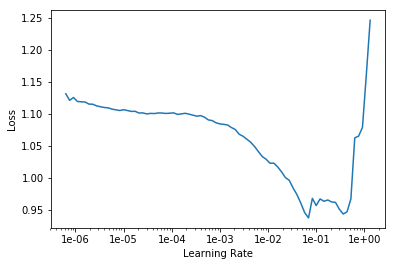

In [44]:
learn.lr_find()
learn.recorder.plot()

#### Gradually unfreeze
In this step we gradually unfreeze the layers and train at each step. As shown in the ULMFiT paper, this procedure allows one to achieve better performance than simply unfreezing all layers at once.

In [45]:
learn.fit_one_cycle(1, 1e-2, moms=moms, wd=wd)

In [46]:
learn.save('exp-01_first')

In [47]:
learn.load('exp-01_first');

In [48]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=moms, wd=wd)

In [49]:
learn.save('exp-01_second')

In [50]:
learn.load('exp-01_second');

In [51]:
# reduce lr
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(3e-3/(2.6**4),3e-3), moms=moms, wd=wd)

In [52]:
learn.save('exp-01_third')

In [53]:
learn.load('exp-01_third');

In [54]:
# unfreeze and retrain
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=moms, wd=wd, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='exp-01_best')])

In [55]:
learn.save('exp-01_final')

In [56]:
learn.load('exp-01_best');

#### Evaluate results
First let's examine the accuracy and $F_1$-score on the validation and test sets:

In [57]:
y_test = test_df['sentiment']
y_valid = valid_df['sentiment']

In [60]:
get_predictions('valid', learn, y_test, y_valid)

========== Classification report on valid set ================
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      1453
     neutral       0.68      0.57      0.62       491
    positive       0.75      0.73      0.74       374

    accuracy                           0.81      2318
   macro avg       0.76      0.74      0.75      2318
weighted avg       0.80      0.81      0.80      2318



In [61]:
get_predictions('test', learn, y_test, y_valid)

========== Classification report on test set ================
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      1816
     neutral       0.69      0.57      0.62       614
    positive       0.74      0.72      0.73       467

    accuracy                           0.81      2897
   macro avg       0.76      0.73      0.74      2897
weighted avg       0.80      0.81      0.80      2897



Not bad! We get an accuracy of 82% and $F_1$-score of 0.76 on the test set, handily outperforming most models on the Kaggle kernels :)

Next, let's have a look at the confusion matrix to see which classes our classifier struggles the most on:

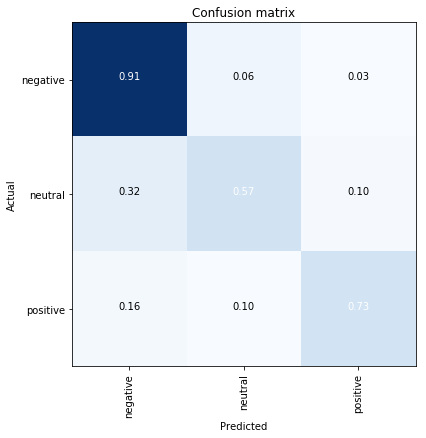

In [62]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, figsize=(6,6))

From the plot we see that our classifier appears to have most trouble with the neutral class, which is incorrectly classified as negative 34% of the time.

## Ideas for improvement

* Tune the hyperparameters of both the language model fine-tuning and classifier steps.
* See whether random oversampling / undersampling helps improve the F1-score.
* Swap out the pretrained `wikitext-103` model for a languare model that is trained on the [Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140) which contains 1.6 million tweets. The idea here is that by training our backbone LM on tweets, owe should be able to generalise better during the fine-tuning stages. (You will need some serious GPU power here!)